In [1]:
import numpy as np
import pylab as plt
from hera_sim.antpos import linear_array

from hera_cal import abscal, datacontainer, redcal, apply_cal, nucal
from copy import deepcopy

In [3]:
nfreqs = 1536
nants = 10
npix = 300
freqs = np.linspace(50e6, 250e6, nfreqs)
sky = np.random.uniform(0, 10, size=(1, npix)) * (freqs[:, None] / 150e6) ** -0.7
l = np.linspace(-1, 1, npix)
beam = np.sinc(l[:, None] / np.sin(0.25 * 150e6 / freqs[None, :]))
s_hat = np.array([l])

antpos = linear_array(nants, sep=15)

bls = []
scale = 1
for ai in antpos:
    for aj in antpos:
        if aj != ai and aj > ai:
            bls.append((antpos[aj] - antpos[ai]) * scale)
            
bls = np.array(bls)[:, 0][:, None]


dx = np.diff(l)[0]
u = (freqs * bls / 2.998e8)

top = np.argsort(sky[0])[:]

#fringe = np.exp(-2 * np.pi * 1j * u[:, :, None] * (l[None, None, :]))
fringe1 = np.exp(-2 * np.pi * 1j * u[:, :, None] * (l[None, None, :] + dx / 2))
fringe2 = np.exp(-2 * np.pi * 1j * u[:, :, None] * (l[None, None, :] - dx / 2))
fringe = 1./(-2j * np.pi * u[..., None]) * (fringe1 - fringe2) / dx
V_sky = np.sum(sky[None, :, :] * beam.T[None] * fringe, axis=-1)
V_sky_inc = np.sum(sky[None, :, top] * beam[top].T[None] * fringe[..., top], axis=-1)



In [373]:
phi = np.random.normal(0, 0.1, size=(1536))

In [374]:
vis_dict = {}
model_dict = {}
true_model_dict = {}
ci = 0

model_bls = []
for ai in antpos:
    for aj in antpos:
        if aj != ai and aj > ai:
            blvecs = (antpos[aj] - antpos[ai])[0]
            g1 = A * np.exp(-1j * blvecs * phi)
            vis_dict[(ai, aj, 'nn')] = (V_sky[ci] * g1)[None]
            model_dict[(ai, aj, 'nn')] = V_sky_inc[ci][None]
            true_model_dict[(ai, aj, 'nn')] = V_sky[ci][None]
            model_bls.append((ai, aj, 'nn'))
            ci += 1
            
vis_dict = datacontainer.DataContainer(vis_dict)
vis_dict.antpos = antpos
vis_dict.freqs = freqs
model_dict = datacontainer.DataContainer(model_dict)
model_dict.antpos = antpos
model_dict.freqs = freqs

reds = redcal.get_reds(antpos)

In [375]:
calibrated_data = deepcopy(vis_dict)
meta, phs_gains = abscal.complex_phase_abscal(vis_dict, model_dict, reds, model_bls, model_bls)
apply_cal.calibrate_in_place(calibrated_data, phs_gains)

<IPython.core.display.Javascript object>


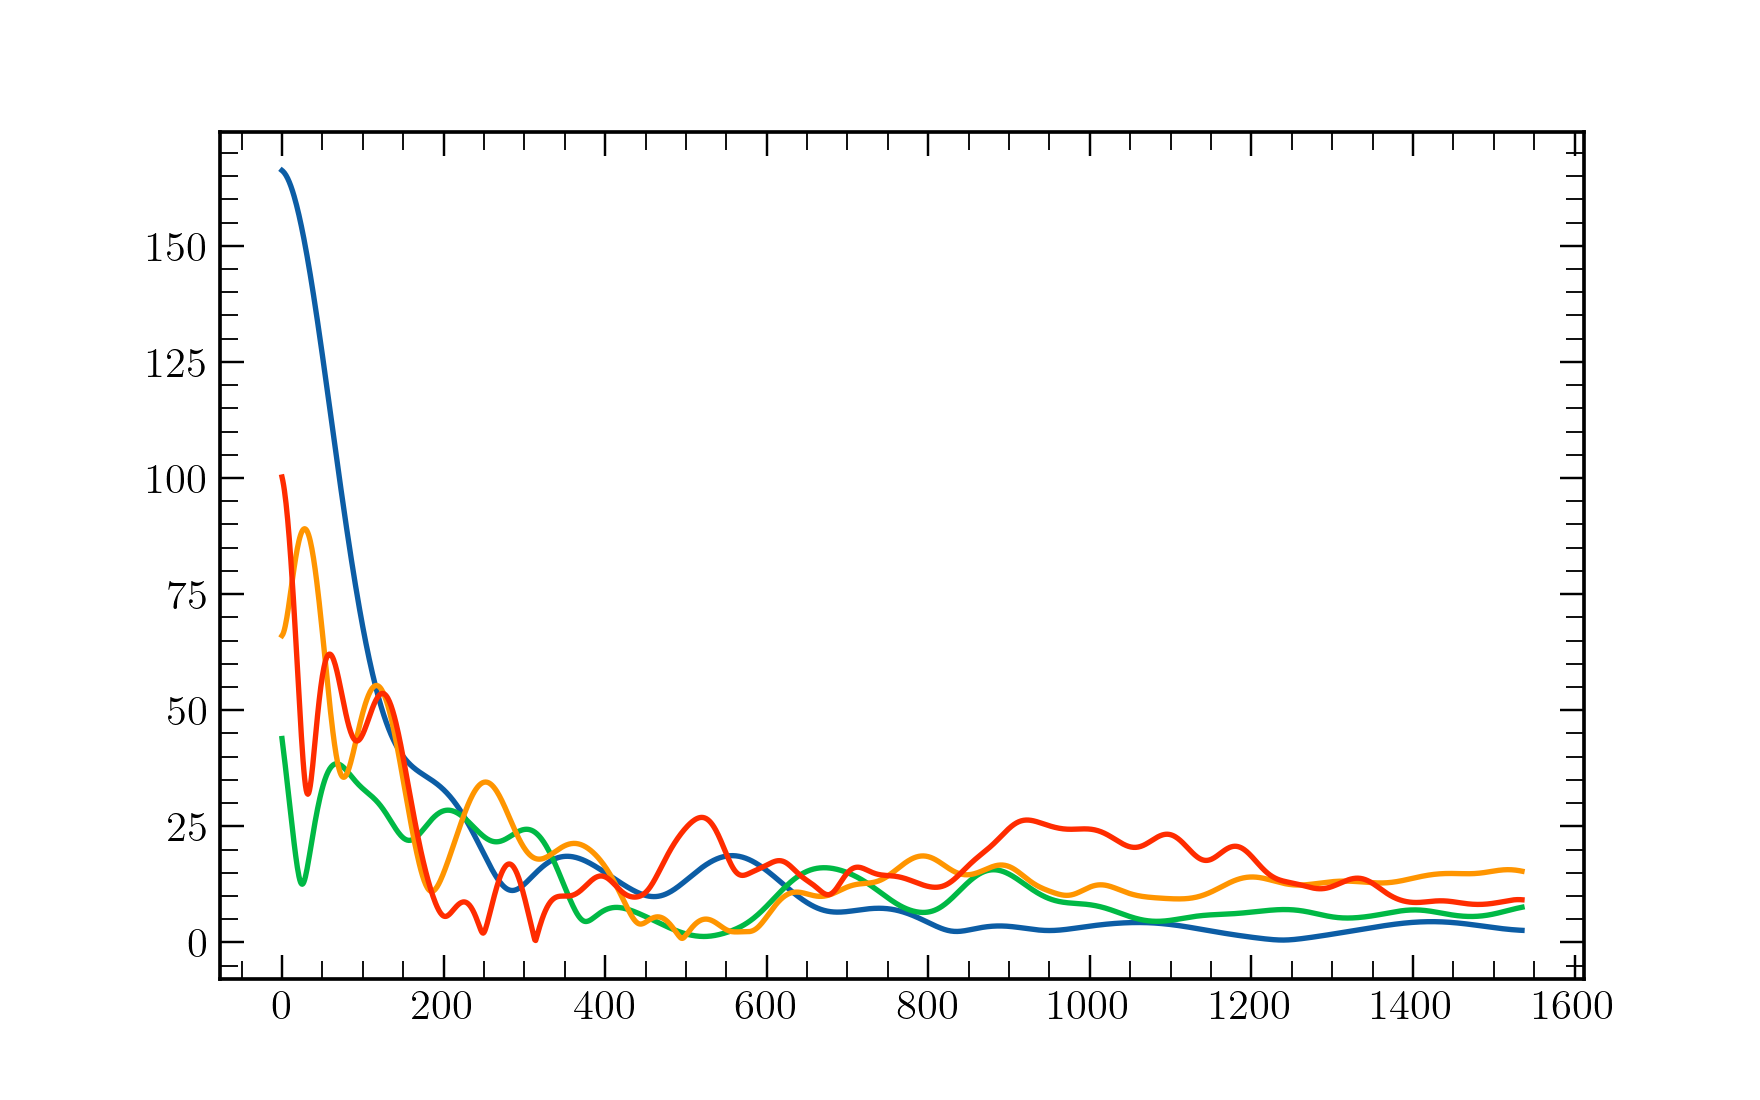

In [376]:
plt.figure()
plt.plot(np.abs(calibrated_data[(0, 1, 'nn')][0]))
plt.plot(np.abs(calibrated_data[(0, 2, 'nn')][0]))
plt.plot(np.abs(calibrated_data[(0, 3, 'nn')][0]))
plt.plot(np.abs(calibrated_data[(0, 4, 'nn')][0]))
plt.show()

In [377]:
import uvtools
def delay_spectra(x):
    """
    """
    return np.abs(uvtools.utils.FFT(x, taper='bh7'))

In [378]:
%matplotlib notebook

<IPython.core.display.Javascript object>


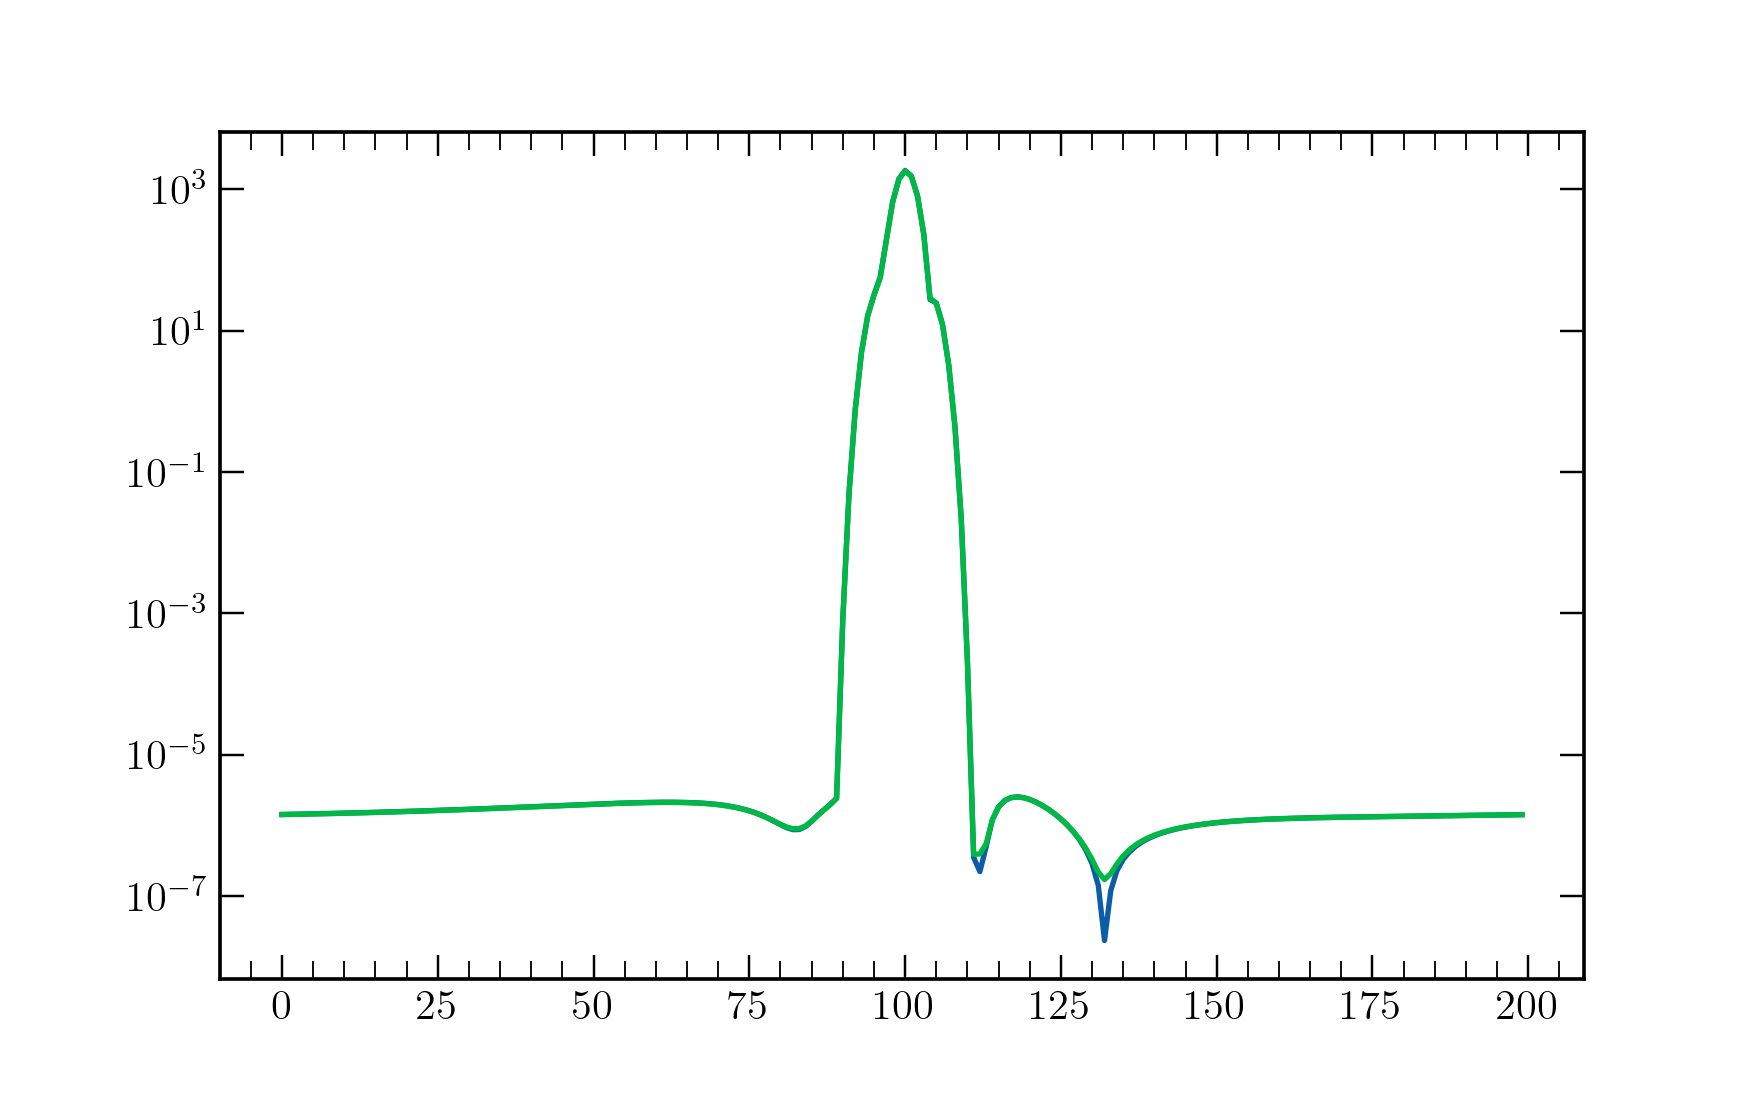

In [379]:
plt.figure()
plt.semilogy(delay_spectra(calibrated_data[(0, 6, 'nn')][0, 500:700]))
plt.semilogy(delay_spectra(true_model_dict[(0, 6, 'nn')][0, 500:700]))
plt.show()

## Now Nucal

In [380]:
wgts = {}
for k in calibrated_data:
    wgts[k] = np.ones_like(calibrated_data[k], dtype=float)

radial_reds = nucal.RadialRedundancy(antpos, reds=reds)
spatial_filters = nucal.compute_spatial_filters(radial_reds, freqs)
spectral_filters = nucal.compute_spectral_filters(freqs, 30e-9)[0].real
nucal_model_comps = nucal.fit_nucal_foreground_model(true_model_dict, wgts, radial_reds, spatial_filters, spectral_filters, return_model_comps=True, tol=1e-9)
nucal_model = nucal.fit_nucal_foreground_model(model_dict, wgts, radial_reds, spatial_filters, spectral_filters, return_model_comps=False, tol=1e-9)

<IPython.core.display.Javascript object>


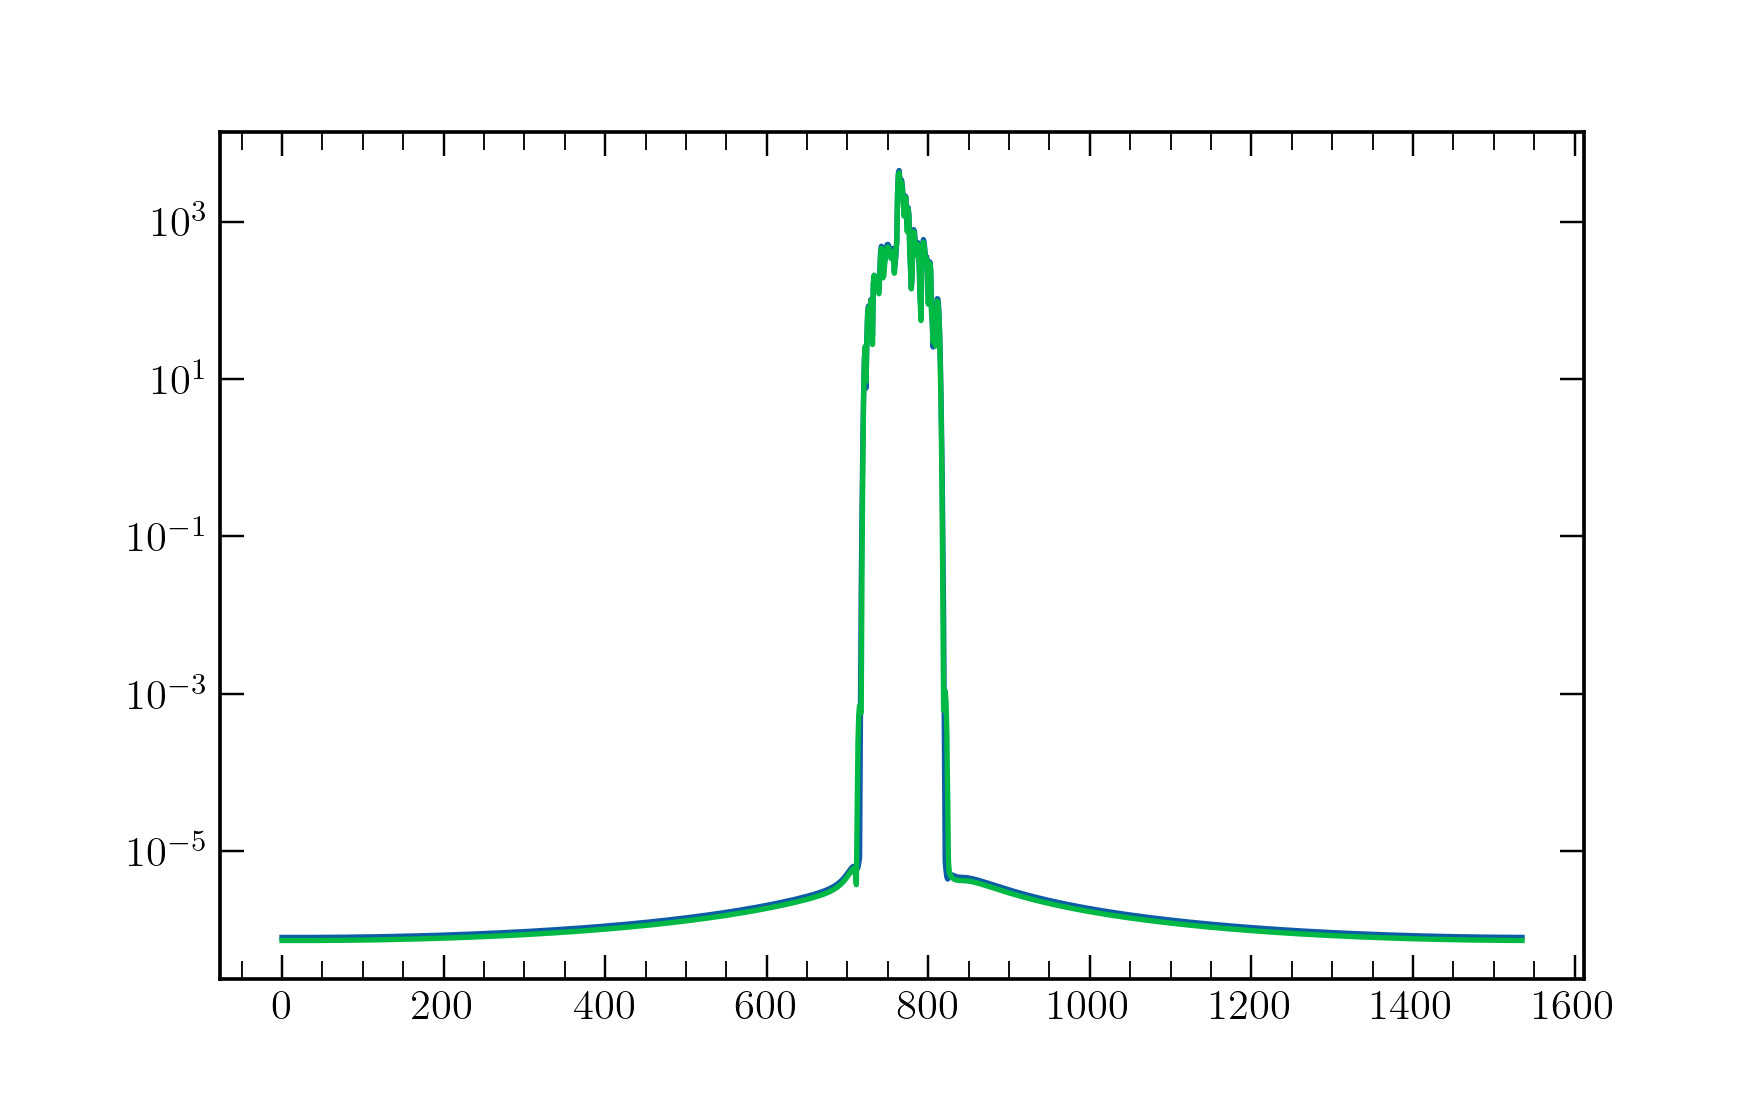

In [381]:
plt.figure()
plt.semilogy(delay_spectra(calibrated_data[(0, 9, 'nn')][0]))
plt.semilogy(delay_spectra(nucal_model[(0, 9, 'nn')][0]))

In [382]:
import nucal as nc
from jax import jit, grad
from jax import numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
import optax

In [383]:
blvec = []
modified_antpos = redcal.reds_to_antpos(reds)
ndims = modified_antpos[0].shape[0]

for (ai, aj, pol) in radial_reds[0]:
    blvec.append(jnp.ones((ndims)) * (modified_antpos[aj] - modified_antpos[ai]))
    
blvec = jnp.array(blvec)
blvec = jnp.transpose(blvec)

In [397]:
_, gains = abscal.complex_phase_abscal(vis_dict, nucal_model, reds, model_bls, model_bls)
nucal_vis = deepcopy(vis_dict)
apply_cal.calibrate_in_place(nucal_vis, gains)

In [398]:
params = {
    'fg_r': nucal_model_comps[(0, 1, 'nn')].real[0],
    'fg_i': nucal_model_comps[(0, 1, 'nn')].imag[0],
    'phi': jnp.zeros((1, nfreqs)) + 1e-4,
}

In [399]:
nucal_model = redcal.RedDataContainer(nucal_model, reds=reds)

In [400]:
from tqdm import tqdm

@jax.jit
def _loss(params, spec, spat, data_r, data_i, blvec):
    """
    """
    model_r, model_i = _data_model_post_redcal(params, spec, spat, blvec)
    return jnp.mean(jnp.square(model_r - data_r) + jnp.square(model_i - data_i))

@jax.jit
def _data_model_post_redcal(
    params, spec, spat, blvec,
):
    """
    """
    vr, vi = _foreground_model(params, spec, spat)
    phase = jnp.einsum('nf,nb->bf', params['phi'], blvec)
    model_r = (vr * jnp.cos(phase) - vi * jnp.sin(phase))
    model_i = (vi * jnp.cos(phase) + vr * jnp.sin(phase))
    return model_r, model_i

@jax.jit
def _data_model_post_redcal_fast(
    params, blvec, vr, vi
):
    """
    """
    phase = jnp.einsum('nf,nb->bf', params['phi'], blvec)
    model_r = (vr * jnp.cos(phase) - vi * jnp.sin(phase))
    model_i = (vi * jnp.cos(phase) + vr * jnp.sin(phase))
    return model_r, model_i

@jax.jit
def _loss_fast(params, vr, vi, data_r, data_i, blvec):
    """
    """
    model_r, model_i = _data_model_post_redcal_fast(params, blvec, vr, vi)
    return jnp.mean(jnp.square(model_r - data_r) + jnp.square(model_i - data_i))
 
def _fit_integration(
    params,
    optimizer,
    spec,
    spat,
    blvec,
    data_r,
    data_i,
    use_minor_cycle=False,
    minor_cycle_steps=20,
    nsteps=1000,
    use_progressbar=True,
):
    """
    """
    opt_state = optimizer.init(params)
    use_tqdm = not use_progressbar
    _value_and_grad = jax.value_and_grad(_loss)
    losses = []

    if use_minor_cycle:
        _value_and_grad_minor_cycle = jax.value_and_grad(_loss_fast)
        minor_cycle_losses = []

    for i in tqdm(range(nsteps), disable=use_tqdm):
        _value, _grad = _value_and_grad(params, spec, spat, data_r, data_i, blvec)
        updates, opt_state = optimizer.update(_grad, opt_state, params)
        params = optax.apply_updates(params, updates)
        losses.append(_value)

        if use_minor_cycle:
            for _ in range(minor_cycle_steps):
                vr, vi = _foreground_model(params, spec, spat)
                _value, _grad = _value_and_grad_minor_cycle(params, vr, vi, data_r, data_i, blvec)
                updates, opt_state = optimizer.update(_grad, opt_state, params)
                params = optax.apply_updates(params, updates)

            minor_cycle_losses.append(_value)

    info = {}
    info["loss"] = jnp.array(losses)

    return params, info

@jax.jit
def _foreground_model(params, spec, spat):
    """
    """
    model_r = jnp.einsum('fm,afn,mn->af', spec, spat, params['fg_r'], optimize=True)
    model_i = jnp.einsum('fm,afn,mn->af', spec, spat, params['fg_i'], optimize=True)
    return model_r, model_i

In [401]:
spat = jnp.array([spatial_filters[k] for k in spatial_filters])
data = jnp.array([nucal_vis[k] for k in spatial_filters])
optimizer = optax.adabelief(1e-2)

In [402]:
nsteps = 50

fit_params, info = _fit_integration(
    params, optimizer, spectral_filters, spat, blvec, data.real, data.imag, nsteps=250, minor_cycle_steps=5, use_minor_cycle=False
)

100%|██████████████████████████████████████████████████████████████████| 250/250 [00:07<00:00, 34.39it/s]


<IPython.core.display.Javascript object>


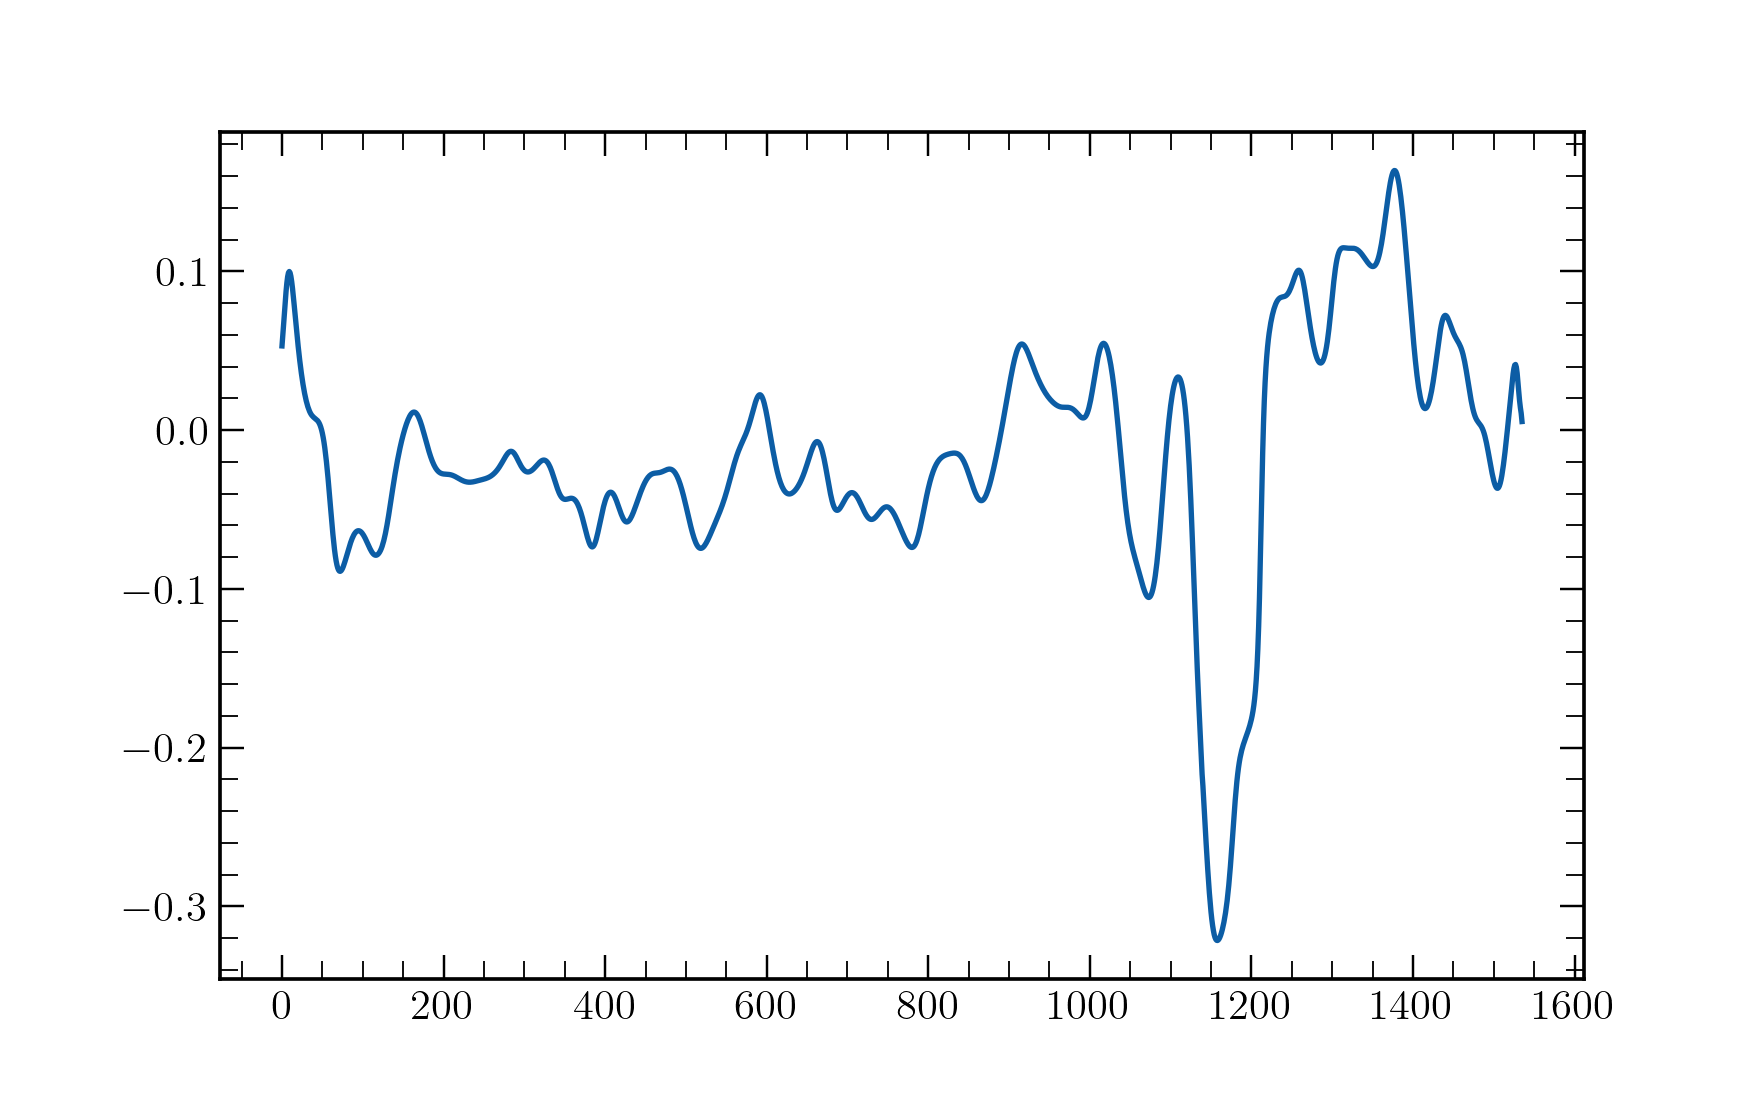

In [413]:
plt.figure()
plt.plot(fit_params['phi'][0])

<IPython.core.display.Javascript object>


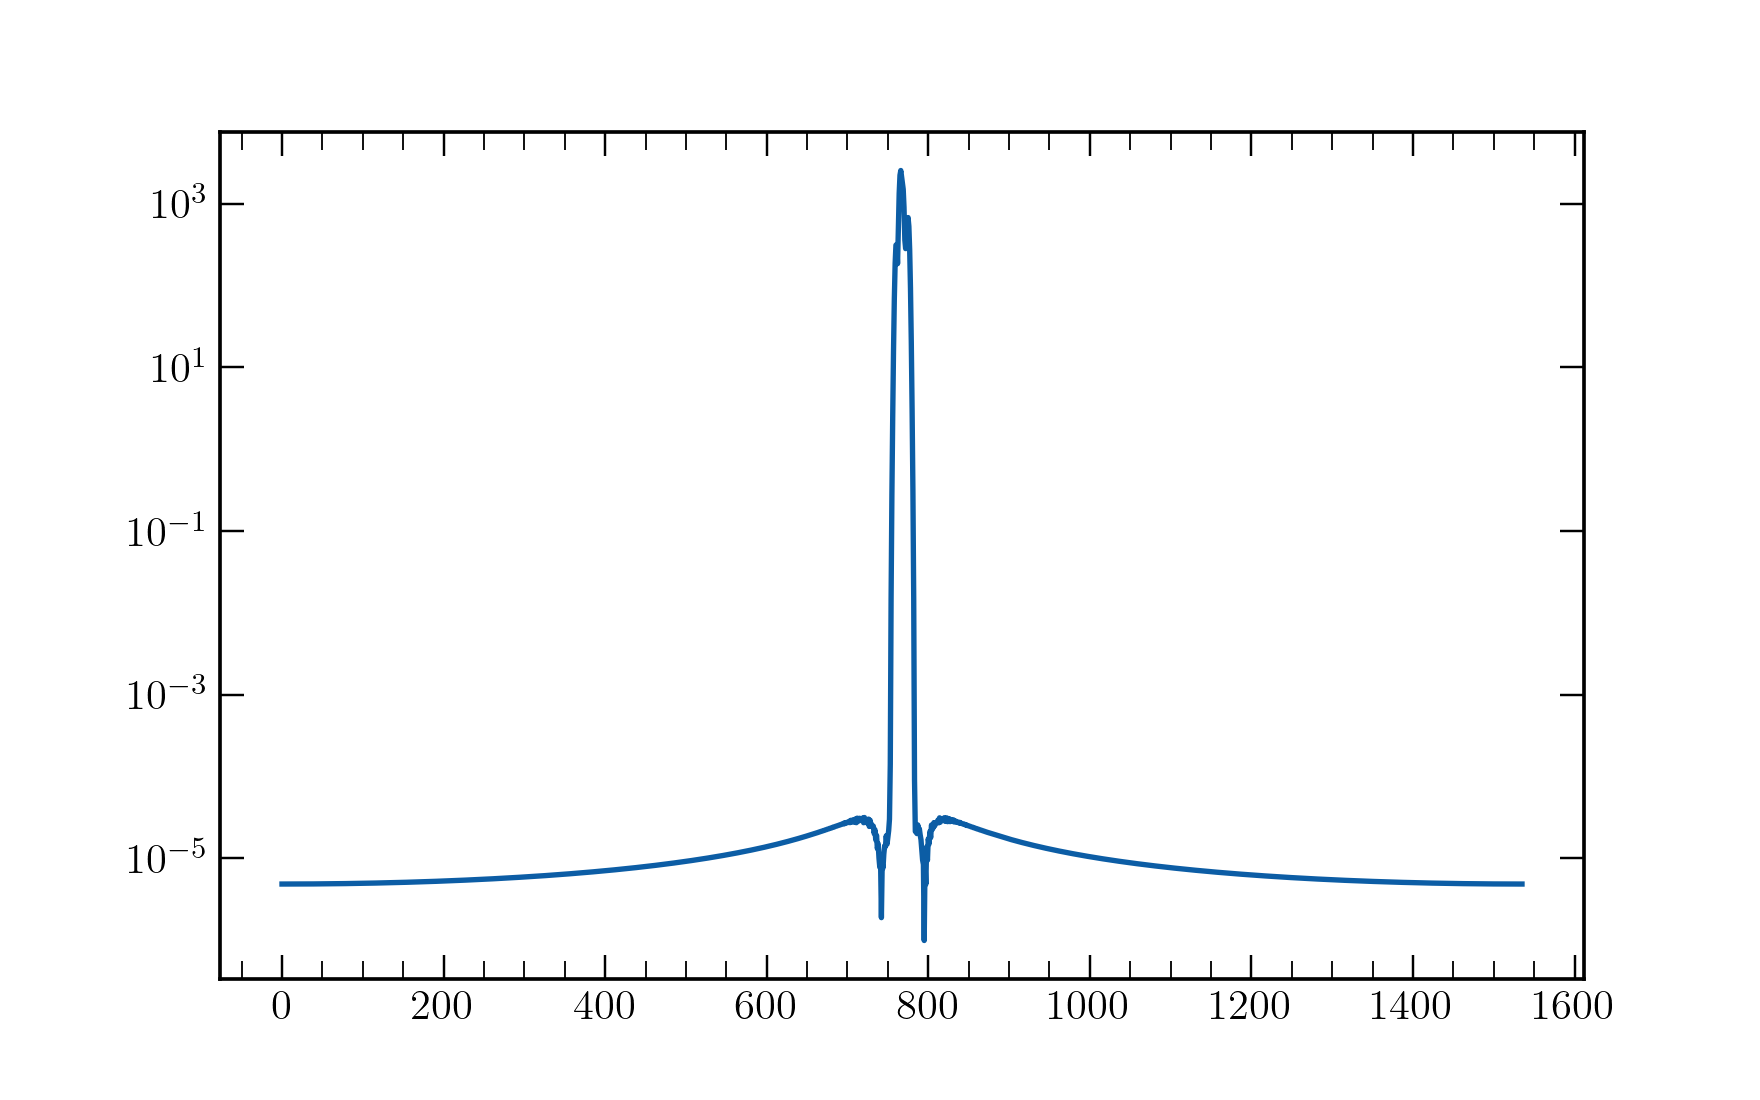

In [408]:
plt.figure()
plt.semilogy(delay_spectra(data[0, 0]))

<IPython.core.display.Javascript object>


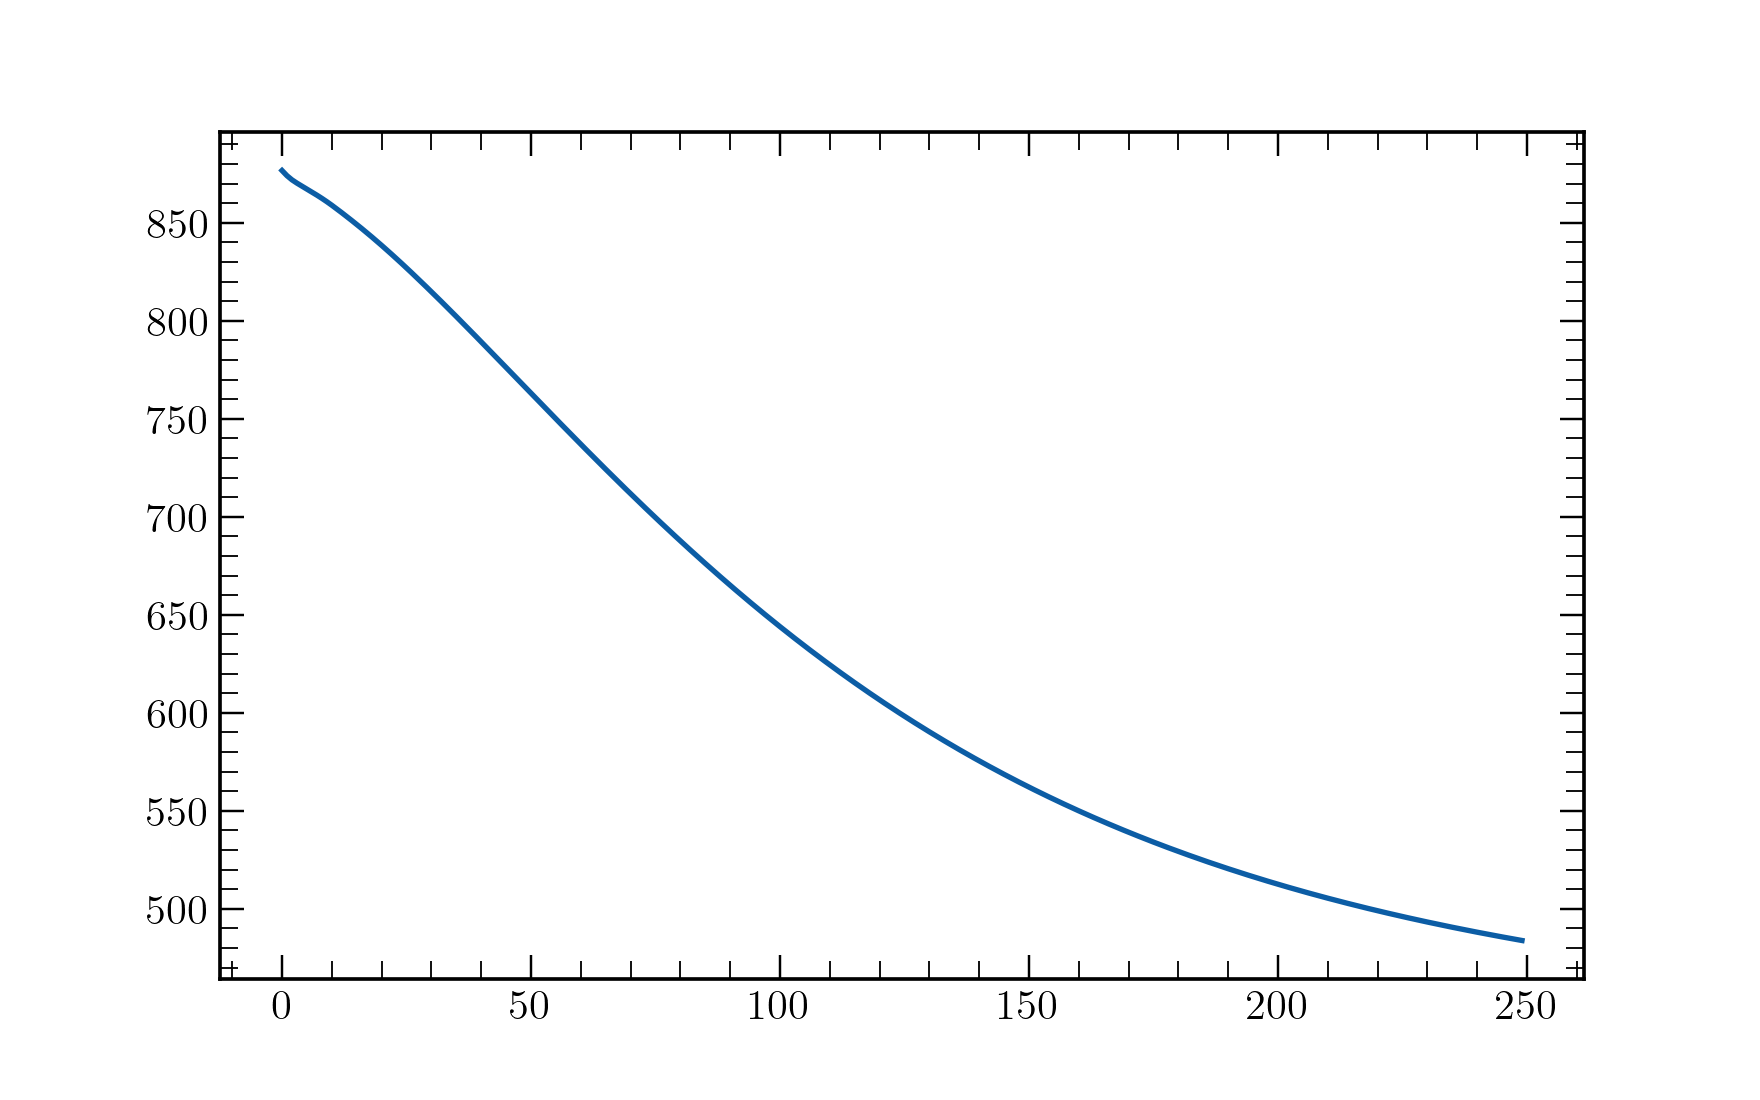

In [403]:
plt.figure()
plt.plot(info['loss'])

In [404]:
phase = jnp.einsum('nf,nb->bf', fit_params['phi'], blvec)
data_c = data[:, 0, :] / np.exp(1j * phase)

<IPython.core.display.Javascript object>


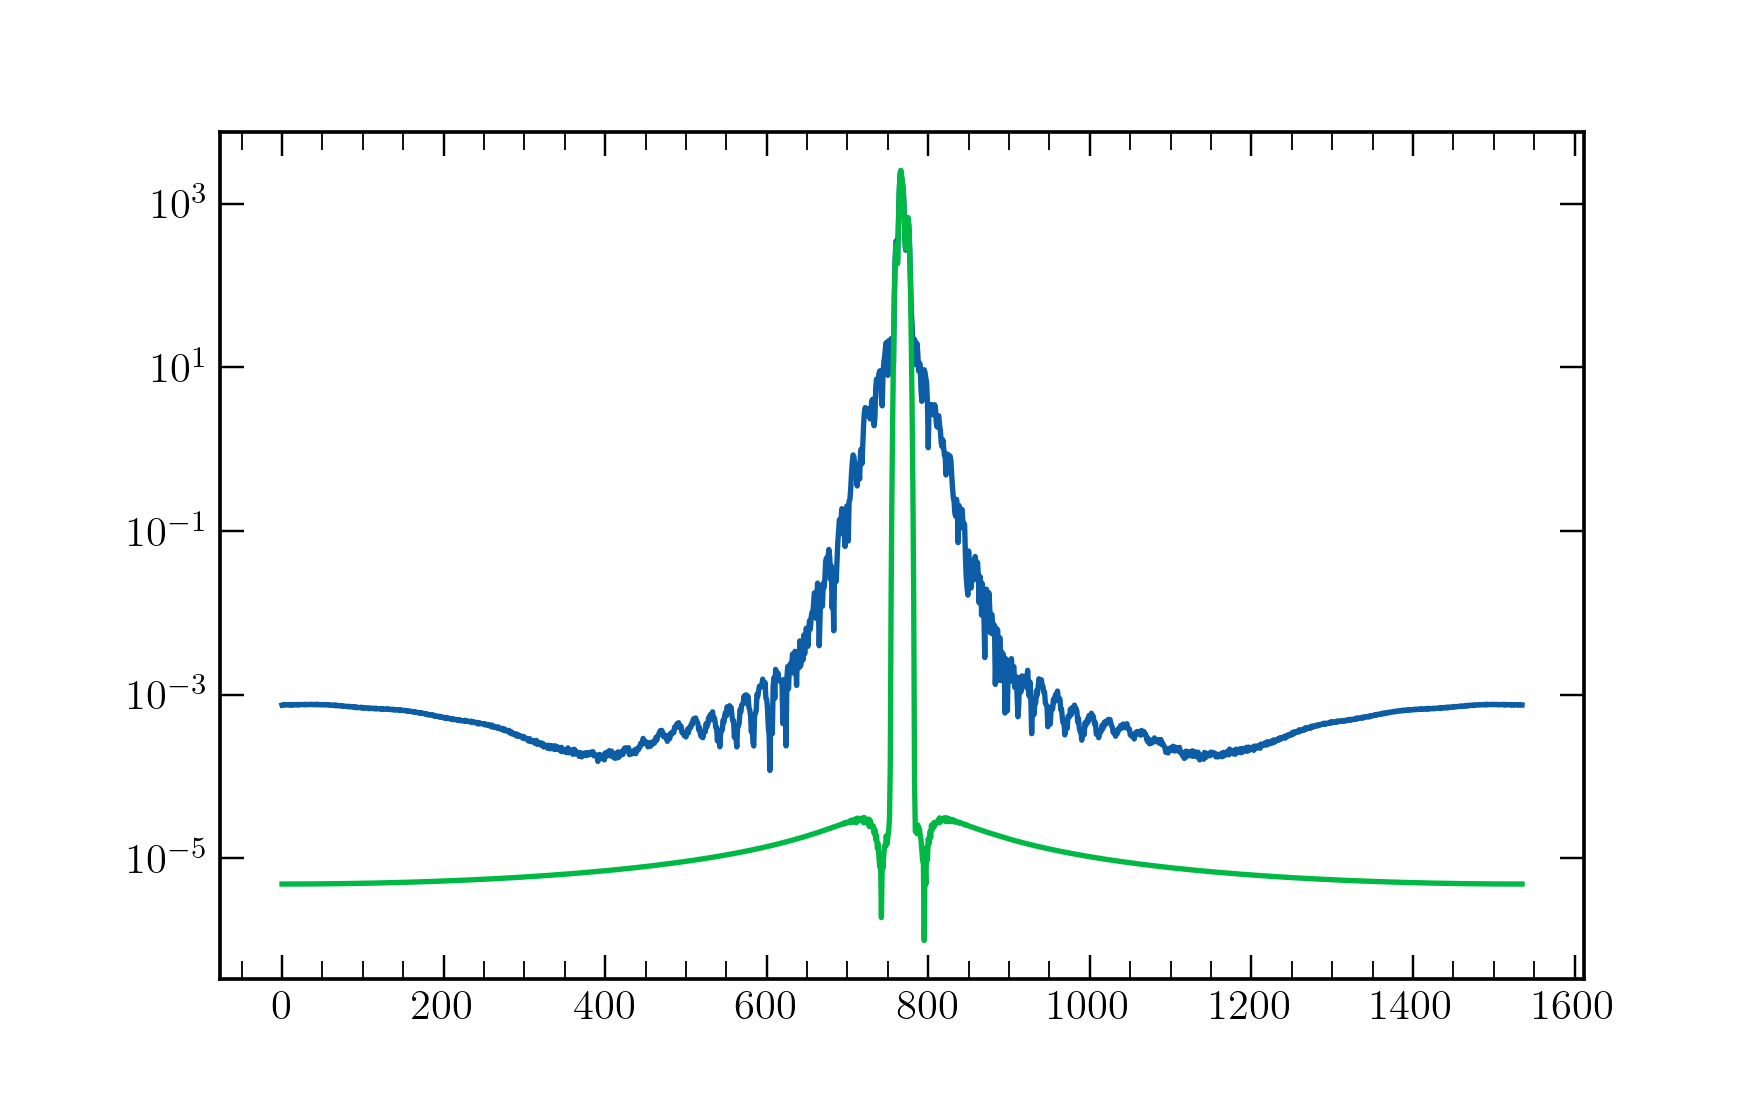

In [405]:
plt.figure()
plt.semilogy(delay_spectra(data_c[0]))
plt.semilogy(delay_spectra(data[0, 0]))
plt.show()

In [368]:
nucal_gain = {}
for k in modified_antpos:
    nucal_gain[(k, "Jnn")] = np.exp(1j * fit_params['phi'] * modified_antpos[k])
    
    

In [369]:
nucal_calibrated = deepcopy(calibrated_data)
apply_cal.calibrate_in_place(nucal_calibrated, nucal_gain)

<IPython.core.display.Javascript object>


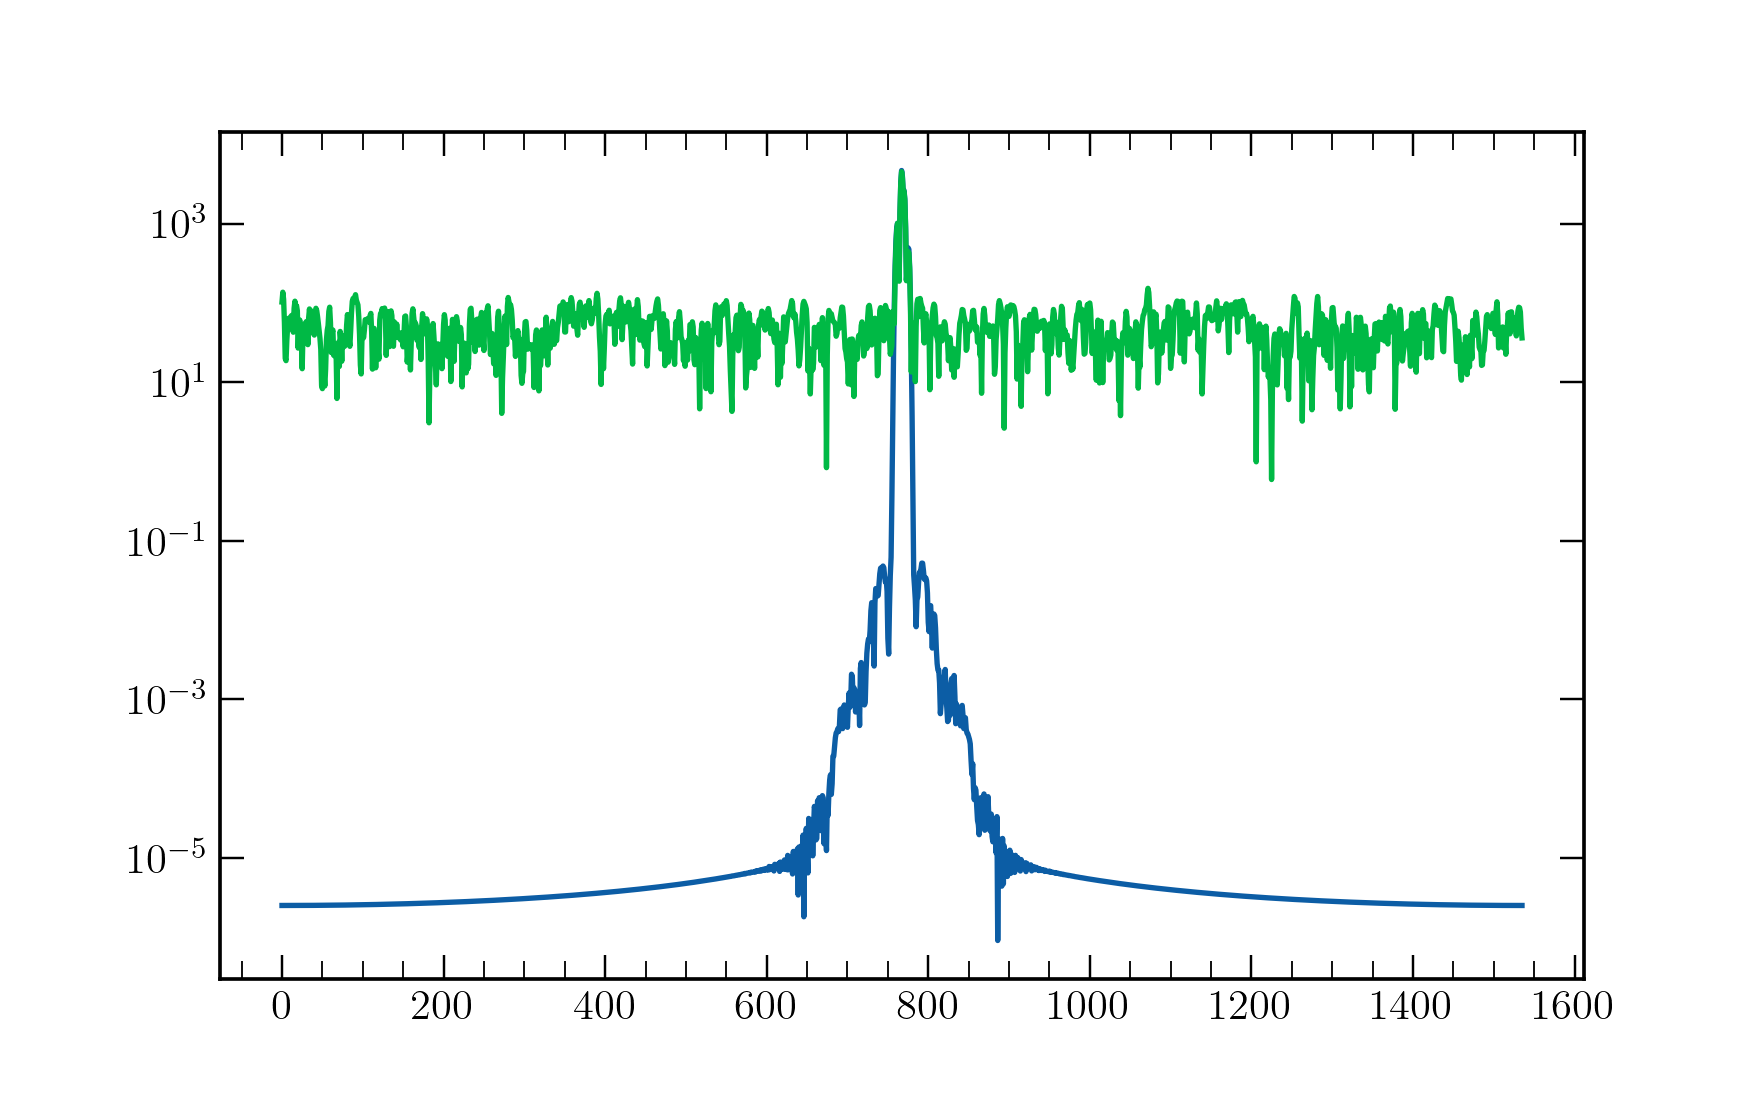

In [370]:
plt.figure()
plt.semilogy(delay_spectra(calibrated_data[(0, 1, 'nn')][0, :]))
plt.semilogy(delay_spectra(nucal_calibrated[(0, 1, 'nn')][0, :]))
#plt.semilogy(delay_spectra(true_model_dict[(0, 1, 'nn')][0, :]))
plt.show()

<IPython.core.display.Javascript object>


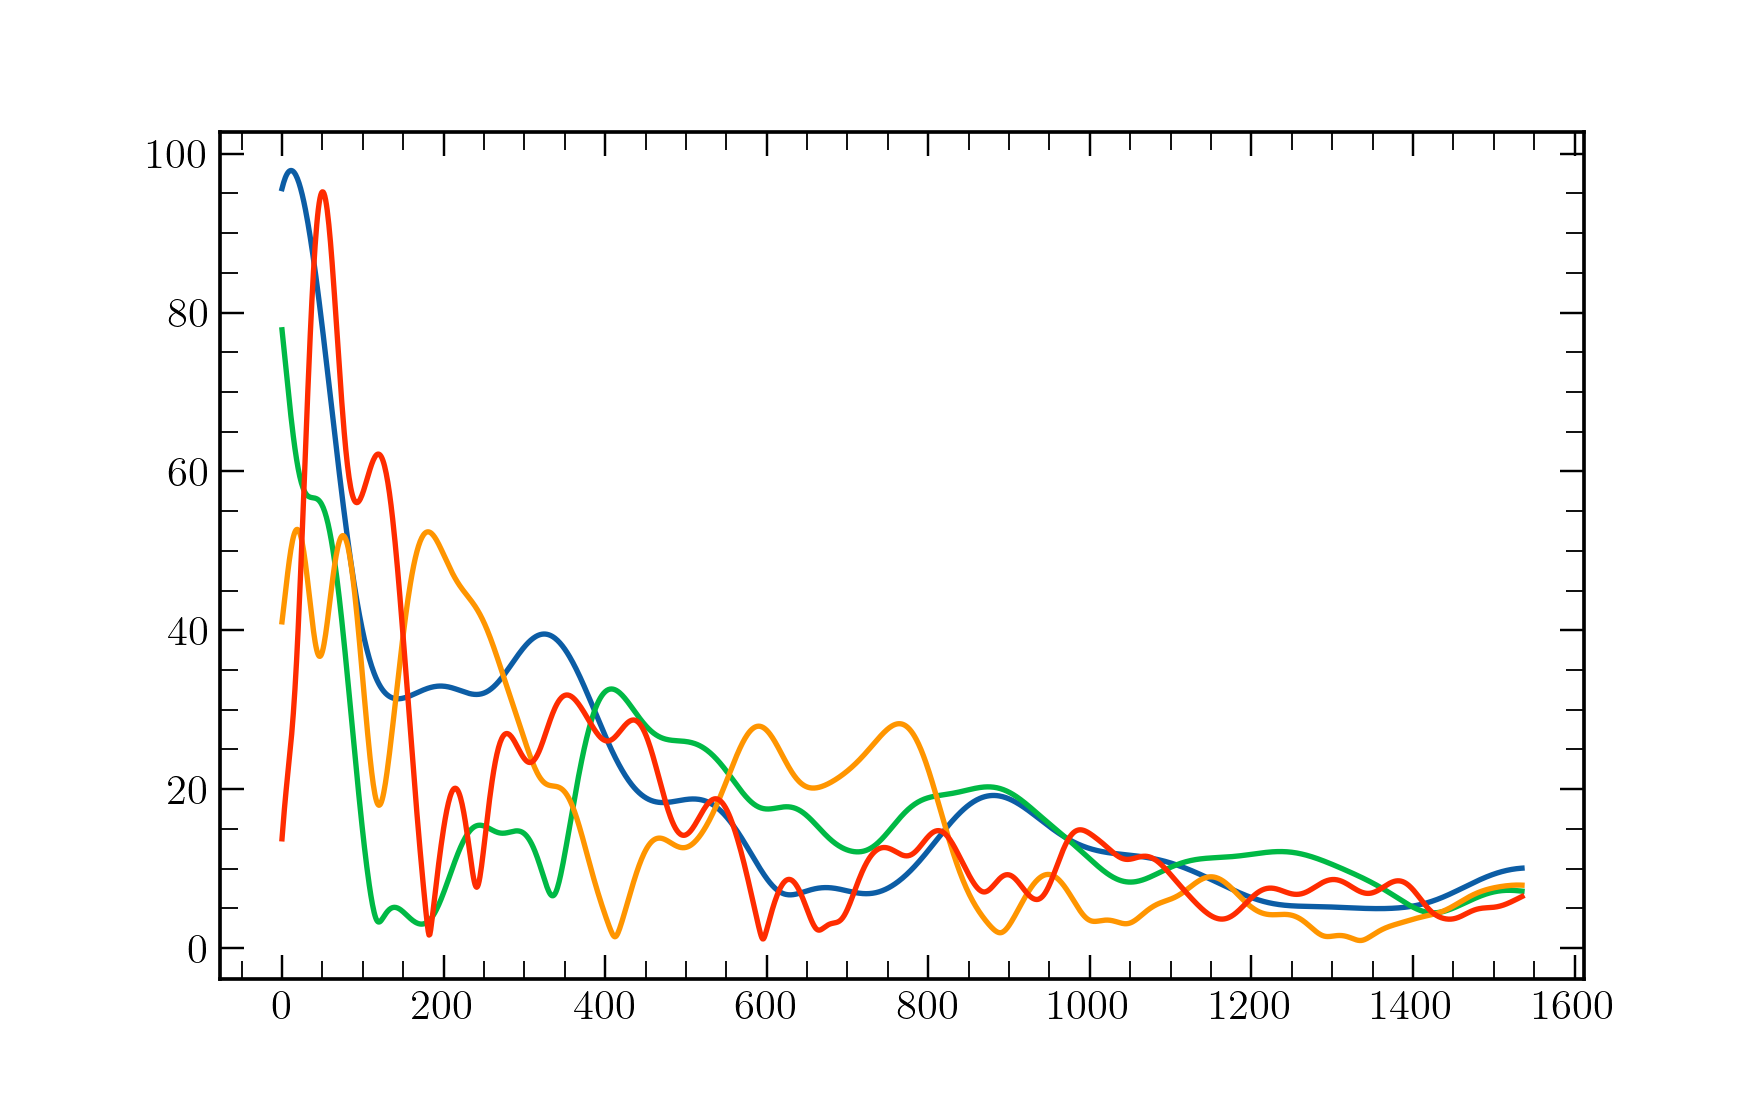

In [331]:
plt.figure()
plt.plot(np.abs(nucal_calibrated[(0, 1, 'nn')].T))
plt.plot(np.abs(nucal_calibrated[(0, 2, 'nn')].T))
plt.plot(np.abs(nucal_calibrated[(0, 3, 'nn')].T))
plt.plot(np.abs(nucal_calibrated[(0, 4, 'nn')].T))

<IPython.core.display.Javascript object>


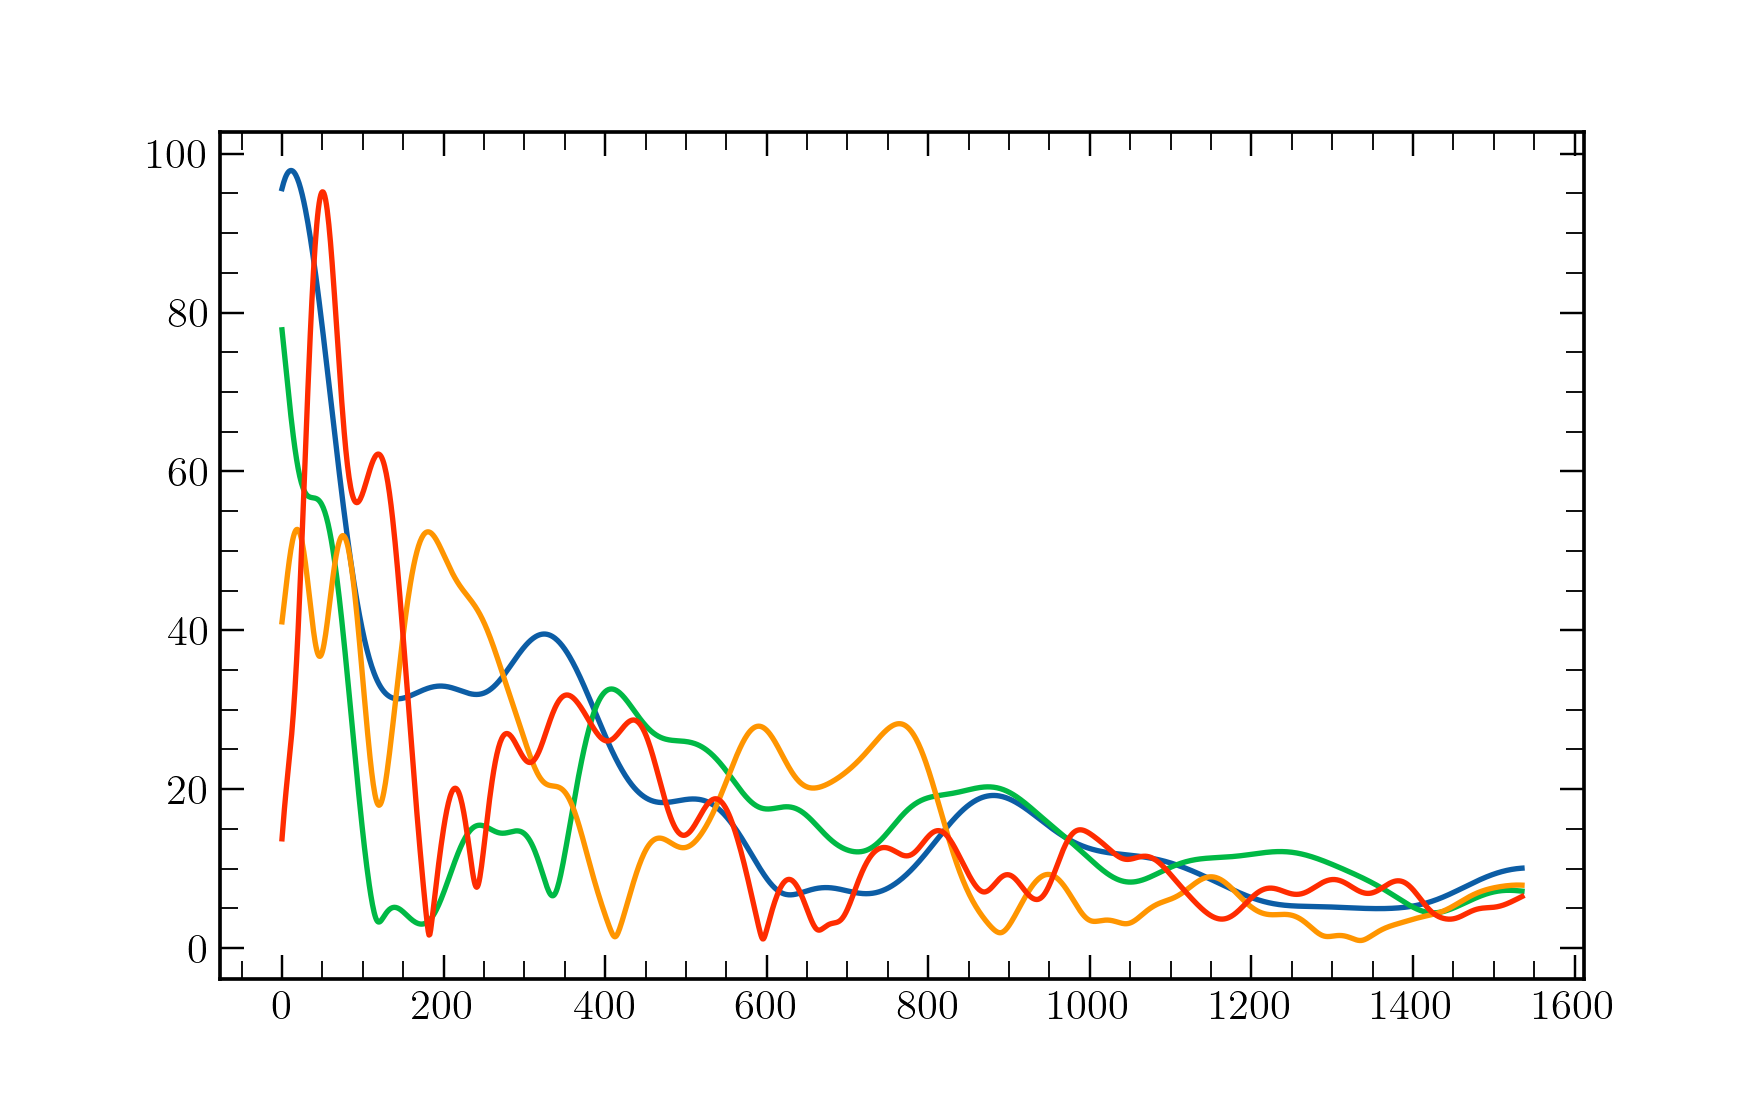

In [332]:
plt.figure()
plt.plot(np.abs(calibrated_data[(0, 1, 'nn')].T))
plt.plot(np.abs(calibrated_data[(0, 2, 'nn')].T))
plt.plot(np.abs(calibrated_data[(0, 3, 'nn')].T))
plt.plot(np.abs(calibrated_data[(0, 4, 'nn')].T))

In [140]:
from hera_sim.antpos import hex_array

In [176]:
antpos = hex_array(11, outriggers=2, split_core=True)
#radial_reds = nucal.RadialRedundancy(antpos, blvec_error_tol=1e-3)
#radial_reds.filter_radial_groups(min_nbls=8)

In [177]:
nfreqs = 1536
npix = 300
freqs = np.linspace(50e6, 250e6, nfreqs)
sky = np.random.uniform(0, 10, size=(1, npix)) * (freqs[:, None] / 150e6) ** -0.7
l = np.linspace(-1, 1, npix)
beam = np.sinc(l[:, None] / np.sin(0.25 * 150e6 / freqs[None, :]))
s_hat = np.array([l])

#antpos = linear_array(nants, sep=15)

bls = []
scale = 1
for (ai, aj, pol) in radial_reds[0]:
    bls.append((antpos[aj] - antpos[ai]) * scale)
            
bls = np.array(bls)[:, 0][:, None]


dx = np.diff(l)[0]
u = (freqs * bls / 2.998e8)

#fringe = np.exp(-2 * np.pi * 1j * u[:, :, None] * (l[None, None, :]))
#fringe1 = np.exp(-2 * np.pi * 1j * u[:, :, None] * (l[None, None, :] + dx / 2))
#fringe2 = np.exp(-2 * np.pi * 1j * u[:, :, None] * (l[None, None, :] - dx / 2))
#fringe = 1./(-2j * np.pi * u[..., None]) * (fringe1 - fringe2) / dx
#V_sky = np.sum(sky[None, :, :] * beam.T[None] * fringe, axis=-1)


In [179]:
ui = 10
blmags = np.array([radial_reds.baseline_lengths[bl] for bl in radial_reds[0]])[:, None]

umin = np.min(blmags * freqs / 2.998e8)
umax = np.max(blmags * freqs / 2.998e8)
umodes = blmags * freqs / 2.998e8

um = np.linspace(umin, umax, 50)

in_bin = []
for ui in um:
    in_bin.append(np.sum((umodes[:, 0] < ui) & (ui <  umodes[:, -1])))

In [180]:
rr = nucal.RadialRedundancy(antpos, blvec_error_tol=1e-3)
rr.filter_radial_groups(min_nbls=25)

blvecs_full = []
size = []
for bl in rr.reds:
    b = antpos[bl[0][1]] - antpos[bl[0][0]]
    if b[0] < 0:
        blvecs_full.append(-b)
    else:
        blvecs_full.append(b)

    size.append(len(bl))

blvecs_full = np.array(blvecs_full)

lines = []
points = []
point_sizes = []
for group in rr:
    rr_bls = []
    for (ai, aj, pol) in group:
        rr_bls.append(antpos[aj] - antpos[ai])
        
    point_sizes.append(np.array([len(rr.get_redundant_group(bl)) for bl in group]))
    rr_bls = np.array(rr_bls)
    mag = np.linalg.norm(rr_bls, axis=-1)
    imax, imin = np.argmax(mag), np.argmin(mag)
    lines.append(np.array([rr_bls[imin], rr_bls[imax]]))
    points.append(rr_bls)
    

In [182]:
ants = [j for group in rr for bl in group for i in rr.get_redundant_group(bl) for j in i[:2]]    
ants = list(set(ants))

In [183]:
%matplotlib notebook

<IPython.core.display.Javascript object>


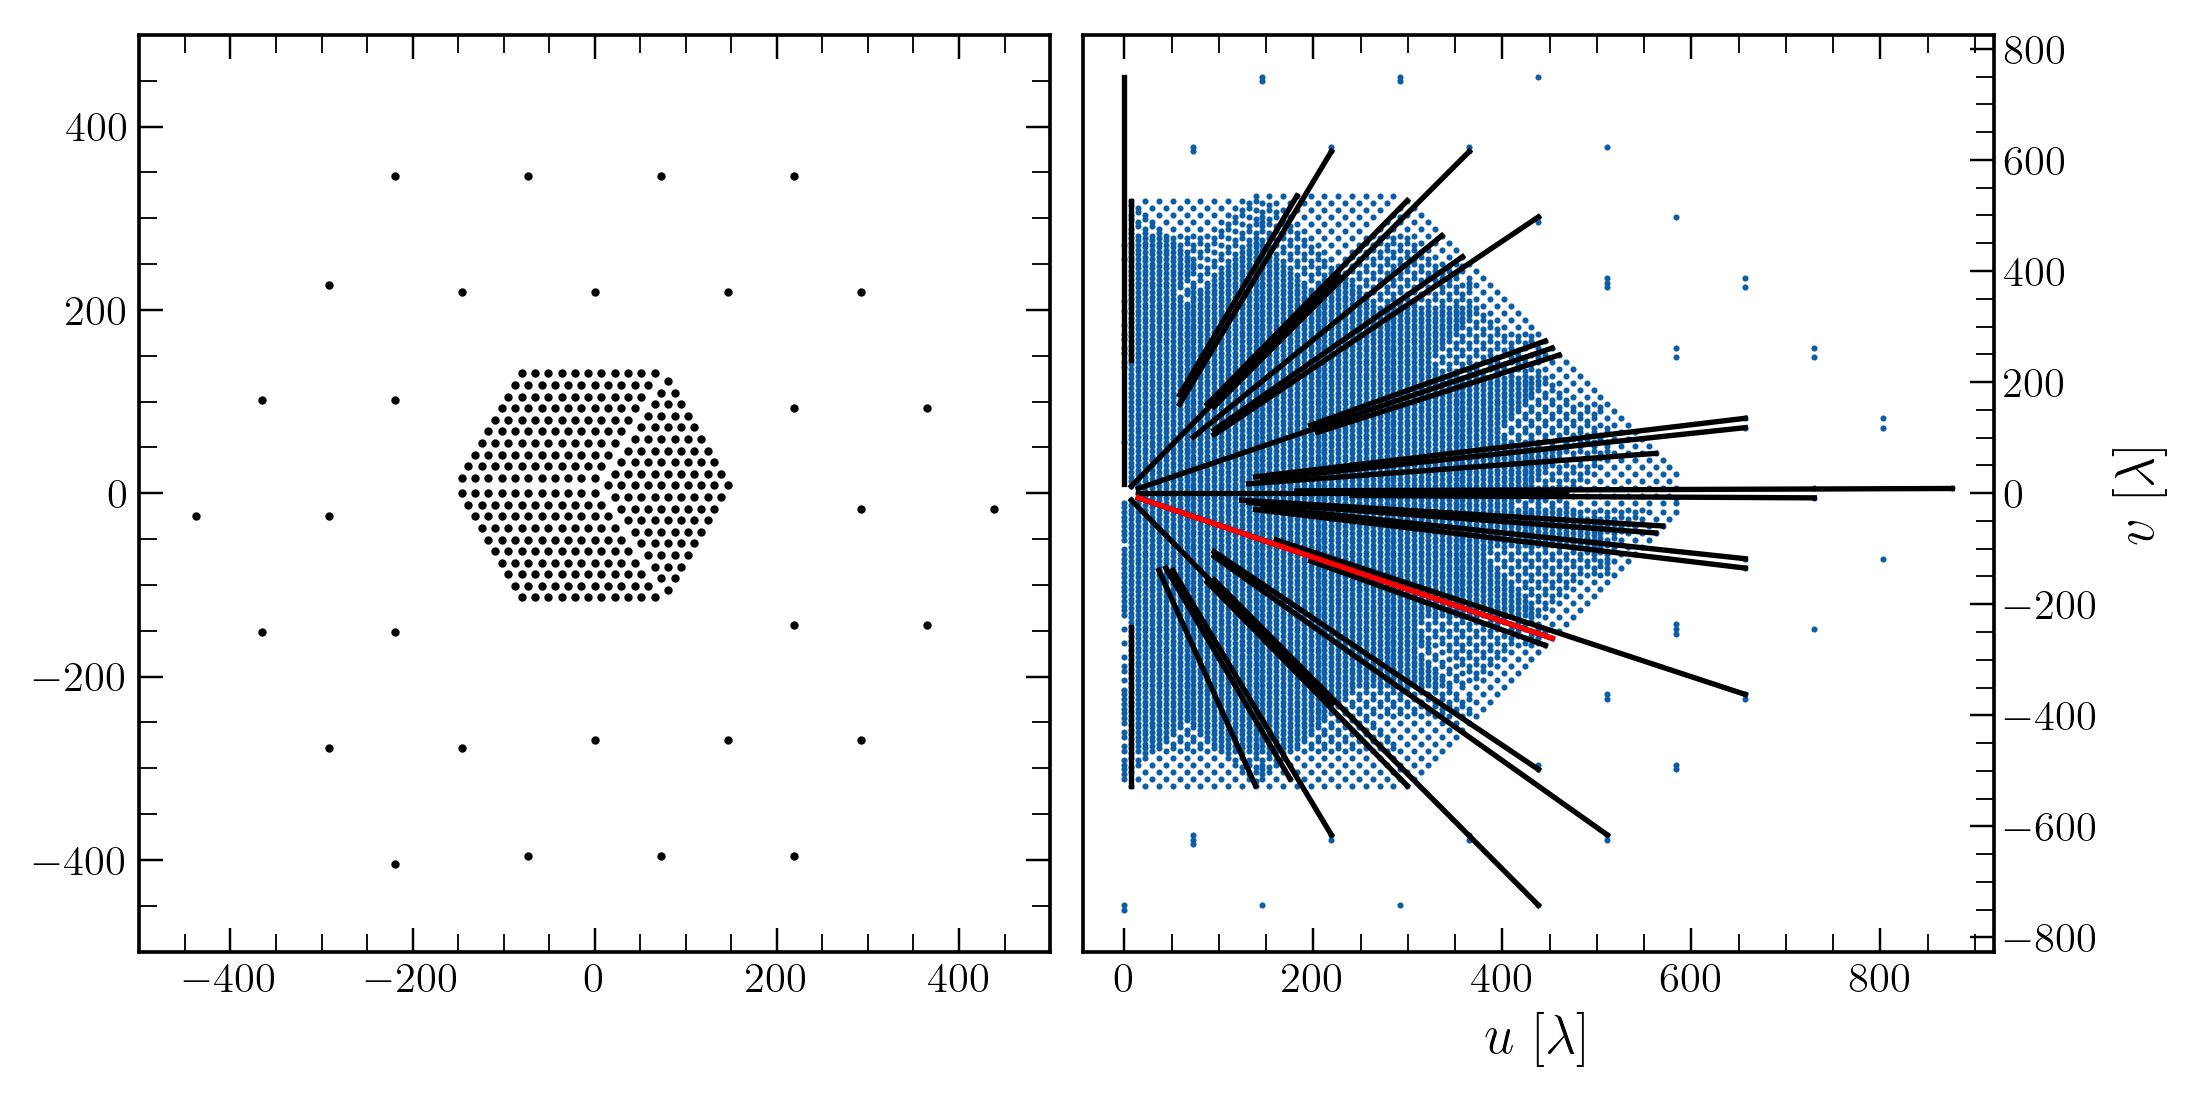

In [184]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.ravel()
axs[1].scatter(blvecs_full[:, 0], blvecs_full[:, 1], s=1)

for k in antpos:
    axs[0].scatter(antpos[k][0], antpos[k][1], color='k', s=3)

for line in lines:
    axs[1].plot(line[:, 0], line[:, 1], color='k')
    
axs[1].plot(lines[0][:, 0], lines[0][:, 1], color='r')

axs[1].set_xlabel(r'$u \ [\lambda]$')
axs[1].set_ylabel(r'$v \ [\lambda]$')
axs[1].yaxis.tick_right()

#axs[0].set_aspect('equal', 'box')
axs[1].yaxis.set_label_position("right")
plt.tight_layout()
axs[0].set_xlim([-500, 500])
axs[0].set_ylim([-500, 500])
plt.show()

<IPython.core.display.Javascript object>


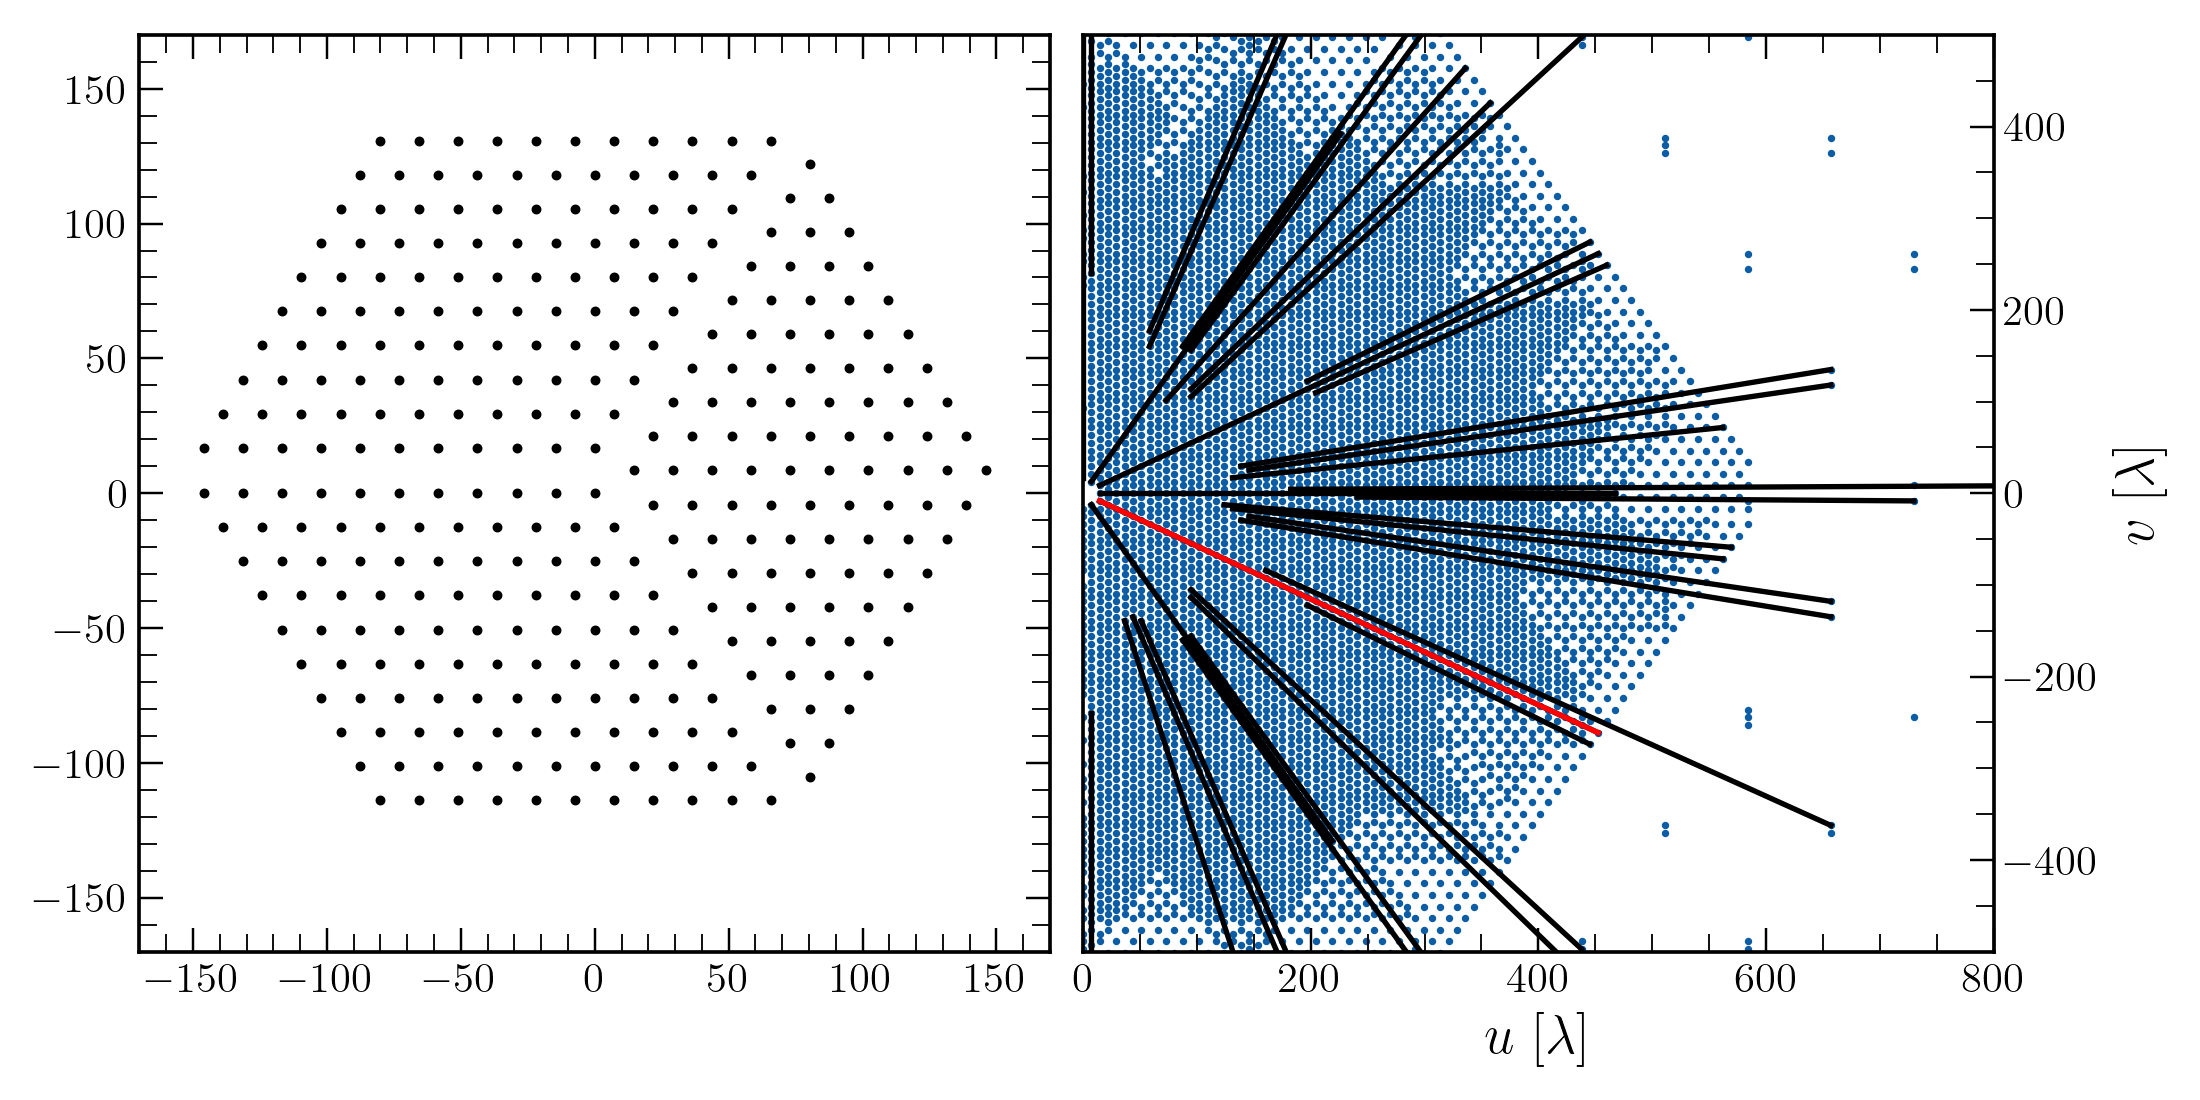

In [202]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.ravel()
axs[1].scatter(blvecs_full[:, 0], blvecs_full[:, 1], s=2)

for k in antpos:
    axs[0].scatter(antpos[k][0], antpos[k][1], color='k', s=5)

for line in lines:
    axs[1].plot(line[:, 0], line[:, 1], color='k')
    
axs[1].plot(lines[0][:, 0], lines[0][:, 1], color='r')

axs[1].set_xlabel(r'$u \ [\lambda]$')
axs[1].set_ylabel(r'$v \ [\lambda]$')
axs[1].yaxis.tick_right()

#axs[0].set_aspect('equal', 'box')
axs[1].yaxis.set_label_position("right")
plt.tight_layout()
axs[0].set_xlim([-170, 170])
axs[0].set_ylim([-170, 170])
axs[1].set_xlim([0, 800])
axs[1].set_ylim([-500, 500])
plt.show()

In [203]:
tot = 0
for group in rr:
    for bl in group:
        tot += len(rr.get_redundant_group(bl))
        
print (tot, sum(map(len, rr.reds)))

12488 61075


In [210]:
for gi, group in enumerate(rr):
    print (gi, [rr.baseline_lengths[bl] for bl in group[:10]])

0 [16.858627860337066, 25.287941790505602, 33.717255720674146, 42.14656965084268, 50.57588358101121, 59.00519751117977, 67.43451144134829, 75.86382537151681, 84.29313930168536, 92.72245323185389]
1 [16.858627860337073, 25.287941790505595, 33.71725572067414, 42.14656965084268, 50.57588358101121, 59.00519751117974, 67.43451144134829, 75.86382537151681, 84.29313930168536, 92.72245323185389]
2 [181.37721282821977, 189.8, 198.223342049652, 206.64717112347154, 215.07142999478103, 223.4960700623913, 231.921049784907, 240.34633344405316, 248.77189015910406, 257.1976930948902]
3 [16.858627860337073, 25.2879417905056, 33.71725572067413, 42.14656965084268, 50.57588358101121, 59.005197511179745, 67.43451144134829, 75.86382537151681, 84.29313930168536, 92.7224532318539]
4 [182.54866017950755, 197.14505657848318, 211.74194986665566, 226.3392439090785, 240.93686586600506, 255.53475954032817, 270.1328808814901, 284.73119487216945, 299.32967332580535, 313.92829329853873]
5 [182.54866017950755, 197.1450

<IPython.core.display.Javascript object>


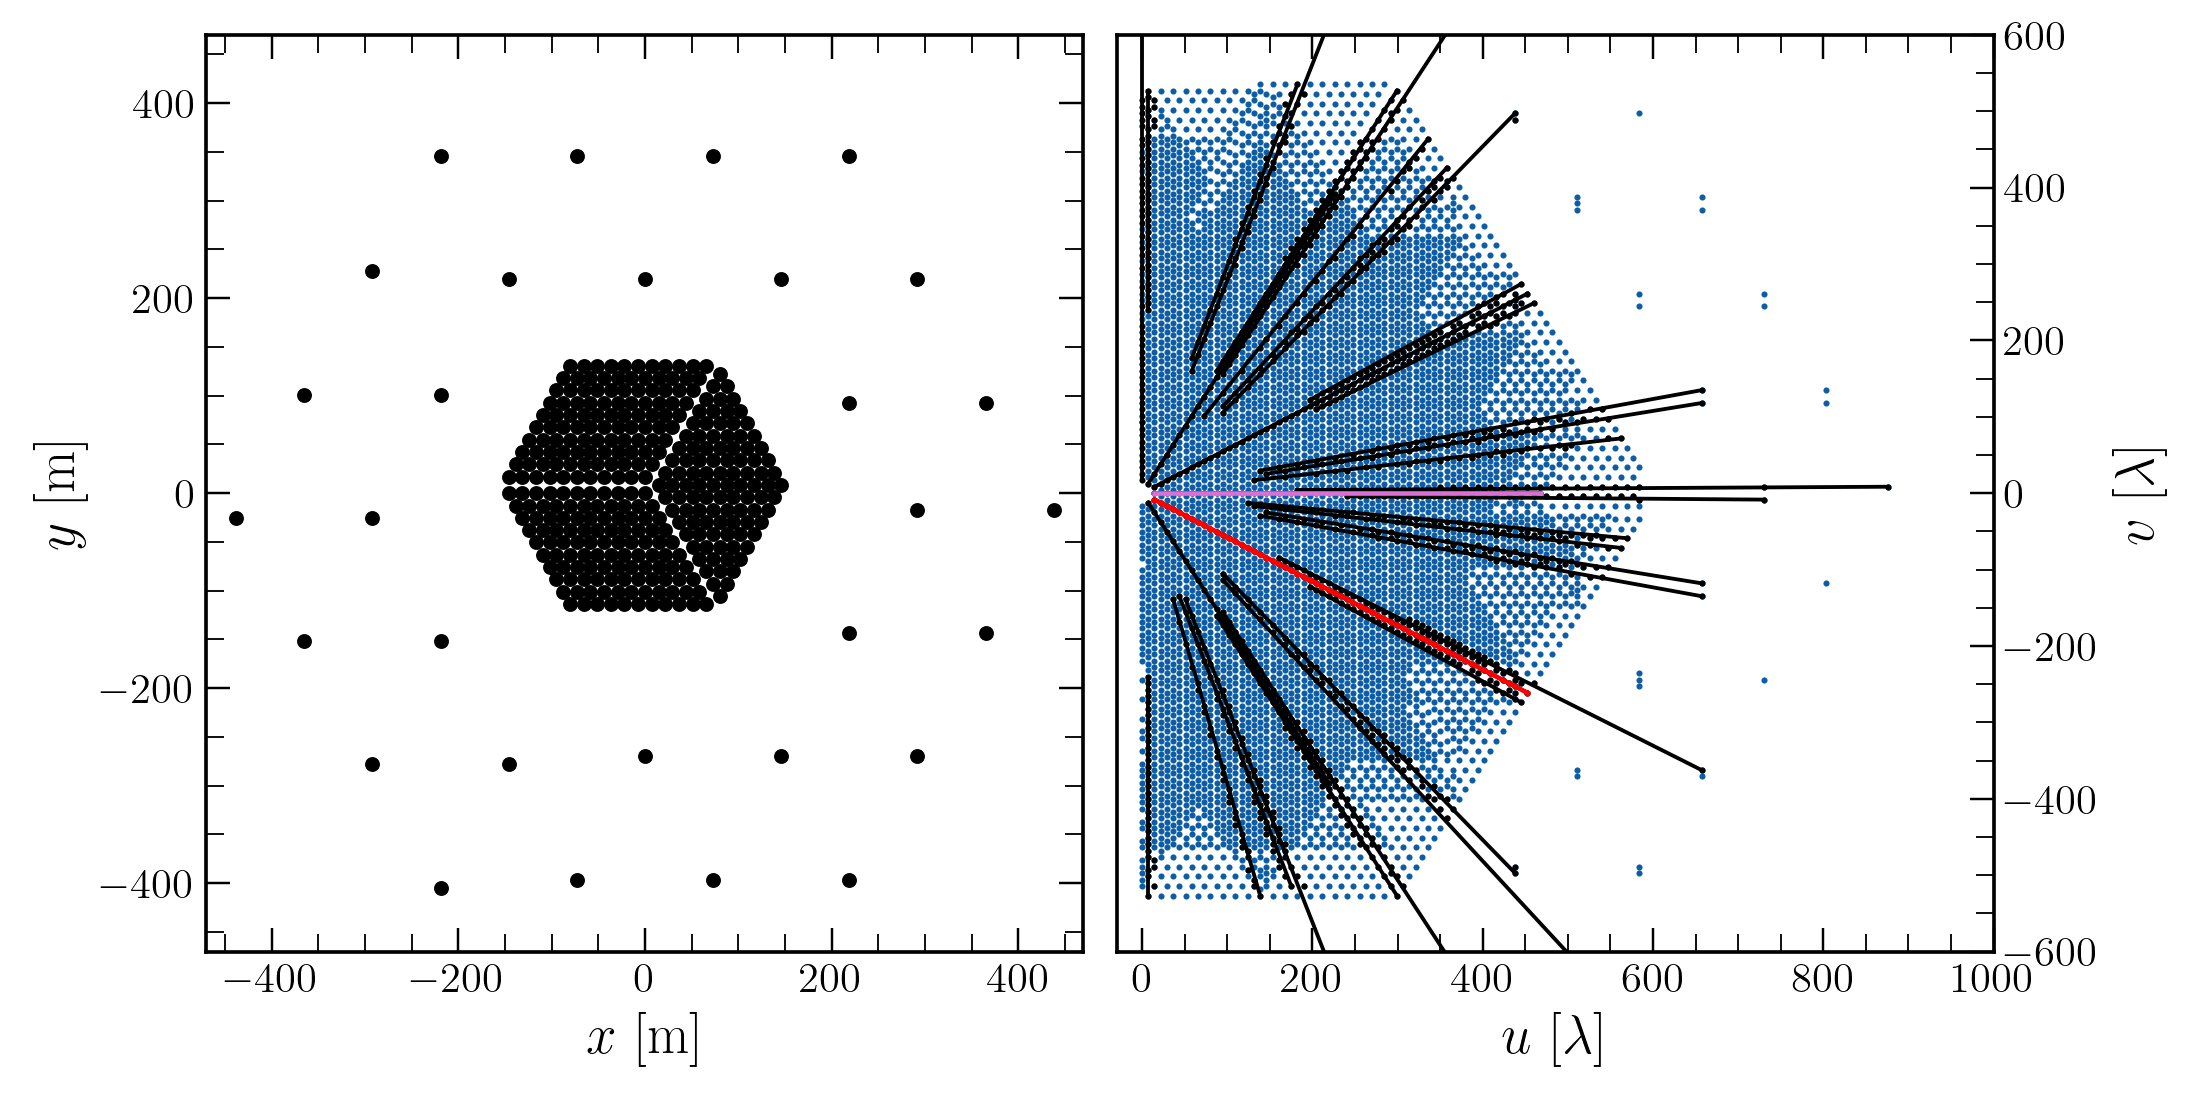

In [218]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs = axs.ravel()
axs[1].scatter(blvecs_full[:, 0], blvecs_full[:, 1], s=1, rasterized=True)

for k in antpos:
    axs[0].scatter(antpos[k][0], antpos[k][1], color='k', s=15, rasterized=True)

for point in points:
    axs[1].scatter(point[:, 0], point[:, 1], color='k', s=1, rasterized=True)
    
for line in lines:
    axs[1].plot(line[:, 0], line[:, 1], color='k', lw=1.25)
    
axs[1].plot(lines[0][:, 0], lines[0][:, 1], color='r', lw=1.5)
axs[1].scatter(points[0][:, 0], points[0][:, 1], color='r', s=1)

axs[1].plot(lines[23][:, 0], lines[23][:, 1], color='orchid', lw=1.5)
axs[1].scatter(points[23][:, 0], points[23][:, 1], color='orchid', s=1)

axs[1].set_xlabel(r'$u \ [\lambda]$')
axs[1].set_ylabel(r'$v \ [\lambda]$')
axs[0].set_xlabel(r'$x \ [\rm m]$')
axs[0].set_ylabel(r'$y \ [\rm m]$')
axs[1].yaxis.tick_right()

#axs[0].set_aspect('equal', 'box')
axs[1].yaxis.set_label_position("right")
plt.tight_layout()
axs[0].set_xlim([-470, 470])
axs[0].set_ylim([-470, 470])
axs[1].set_xlim([-30, 1000])
axs[1].set_ylim([-600, 600])
plt.savefig("antenna_positions.pdf", dpi=300, bbox_inches='tight')

<IPython.core.display.Javascript object>


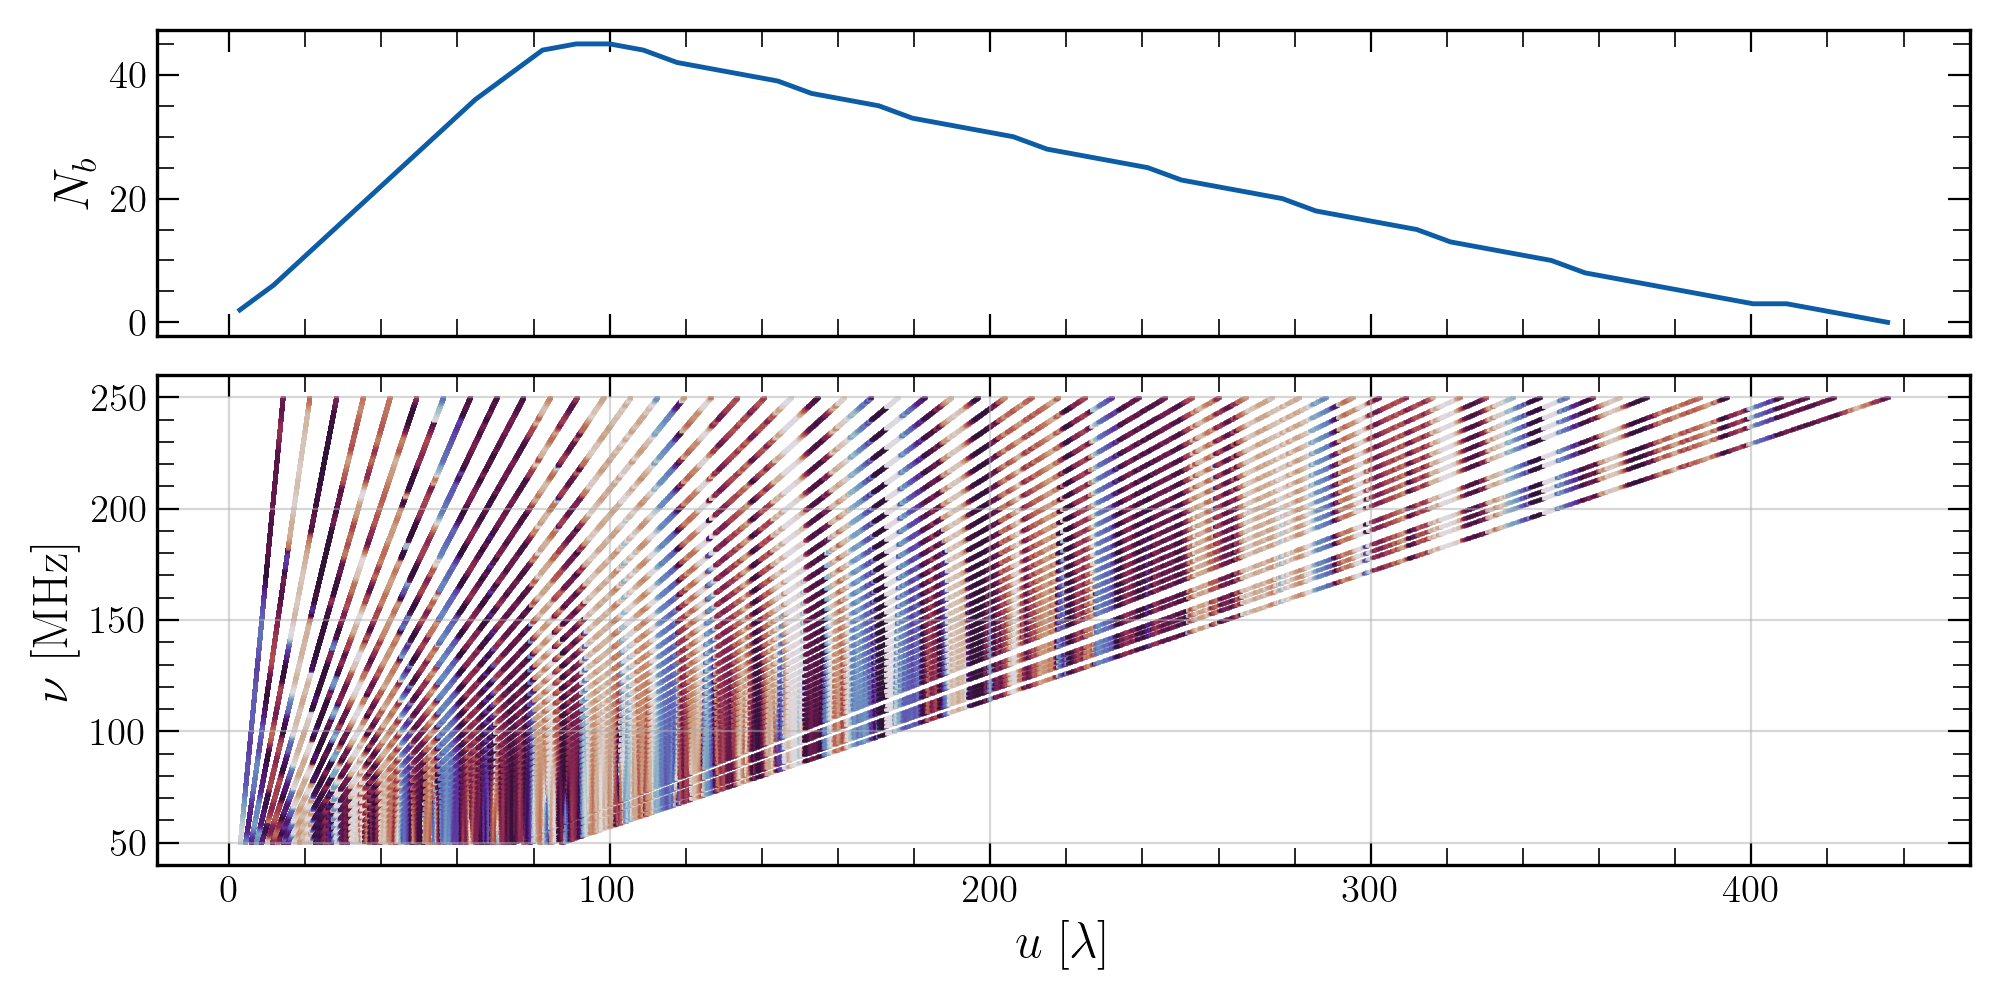

In [645]:
fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=True, dpi=100, constrained_layout=True, gridspec_kw={'height_ratios': [1.25, 2]})
axs = axs.ravel()
for bi, bl in enumerate(radial_reds[0]):
    blmag = radial_reds.baseline_lengths[bl]
    axs[1].scatter(blmag * freqs / 2.998e8, freqs / 1e6, c=np.angle(V_sky[bi]), marker='|', s=1.25, cmap="twilight_shifted", vmin=-np.pi, vmax=np.pi, rasterized=True)

#axs[0].hist(np.ravel(bls * freqs / 2.998e8), bins=100, histtype='step')
axs[0].plot(um, ndimage.gaussian_filter1d(in_bin, 1))
plt.xlabel(r'$u \ [\lambda]$')
plt.ylabel(r'$\nu \ [\rm MHz]$')
plt.grid(alpha=0.5)
plt.tight_layout()
axs[0].set_ylabel(r'$N_b$')
plt.savefig("hera_sampling_density.pdf", dpi=300)